# Web Scraping

Most webpages are created for humans, but that doesn't mean we can't write computers to "scrape" information out of them.  Today, we're going to learn selenium, a powerful tool that allows us to automate typing, clicks, and other actions in a real web browser.  It will help us pull data from sites with a number of challenging designs, several of which are illustrated by simple examples here: https://tyler.caraza-harter.com/cs320/tricky/scrape.html

First, let's take a look web scraping via two simpler tools, `requests` and `BeautifulSoup`.

## requests and BeautifulSoup

If you don't already have these packages, install them: `pip3 install requests beautifulsoup4`.  `requests` lets us to execute GET (download) and other HTTP requests.  Often, the file requested might be an HTML file.  In this case, BeautifulSoup lets us extract information from HTML tags.

We'll try to scrape the tabels from this page: https://tyler.caraza-harter.com/cs320/tricky/page1.html.  Visit it, right click on the page, then click "View Page Source".

You'll see something like this:

```html
<html>
  <head>
    <script src="https://code.jquery.com/jquery-3.4.1.js"></script>
    <script>
      ... LOTS OF JAVASCRIPT CODE HERE...
    </script>
  </head>
  <body onload="main()">
    <h1>Welcome</h1>
    <h3>Here's a table</h3>
    <table border=1 id='alpha'>
      <tr><td>A</td><td>B</td><td>C</td></tr>
      <tr><td>1</td><td>2</td><td>3</td></tr>
      <tr><td>4</td><td>5</td><td>6</td></tr>
    </table>

    <h3>And another one...</h3>
  </body>
</html>
```

Inside the `<script>` tags there is code in the JavaScript programming language.  One the page is loaded in the browser, this code starts executing, and may make some changes to the tags/elements.

In the above HTML, we see one table (`<table>`); however, the JavaScript code will automatically generate a second table.  With the `requests` module, we can only grab the version of the page **before** the JavaScript runs.  So in this example, we'll just extract data from that first table (later we'll use Selenium to get data from the second table too).

In [1]:
import requests
r = requests.get("https://tyler.caraza-harter.com/cs320/tricky/page1.html")
r.raise_for_status()
type(r)

requests.models.Response

In [2]:
html = r.text
type(html)

str

In [3]:
html[:200]

'<html>\n  <head>\n    <script src="https://code.jquery.com/jquery-3.4.1.js"></script>\n    <script>\n      function addTable() {\n        var html = "<table border=1 id=\'coords\'>\\n";\n        html += "<tr><'

Above, we see we can use `.get` to request a web page; a `Response` object is returned.  The `.raise_for_status()` call makes sure we crash if it is an error page (such as a "404 missing" error).

Once we're sure the page is good, we can access the `.text` attribute of the `Response` object.  As show above, this is a regular string.

We'll use BeautifulSoup to convert this text to a `BeautifulSoup` object, which is a searchable tree of elements.

In [4]:
from bs4 import BeautifulSoup
doc = BeautifulSoup(html, "html.parser")
type(doc)

bs4.BeautifulSoup

Looks like there are three tr tags (table rows) on the page:

In [5]:
trs = doc.findAll("tr")
len(trs)

3

In [6]:
trs

[<tr><td>A</td><td>B</td><td>C</td></tr>,
 <tr><td>1</td><td>2</td><td>3</td></tr>,
 <tr><td>4</td><td>5</td><td>6</td></tr>]

They are represented as `Tag` objects; `Tag` elements looks like HTML when converted to a string.  Alternatively, the `.text` attribute shows us the raw content, without all the surrounding HTML.

In [7]:
str(trs[0])

'<tr><td>A</td><td>B</td><td>C</td></tr>'

In [8]:
trs[0].text

'ABC'

The `findAll` method can be used on the whole page, or to search within a single element/Tag.

In [9]:
len(doc.findAll("td")) # 9 cells (td=table data) in whole page

9

In [10]:
len(trs[0].findAll("td")) # 3 cells (td=table data) in first row

3

Let's right a method that does three things:
1. fetch a page using `requests.get`
2. parse that page with BeautifulSoup
3. search through the tree for rows/cells, placing them in a list of lists

In [11]:
def grab_table(url):
    r = requests.get(url)
    r.raise_for_status()
    doc = BeautifulSoup(r.text)
    rows = []
    for tr in doc.findAll("tr"):
        row = []
        for td in tr.findAll("td"):
            row.append(td.text)
        rows.append(row)
    return rows

rows = grab_table("https://tyler.caraza-harter.com/cs320/tricky/page1.html")
rows

[['A', 'B', 'C'], ['1', '2', '3'], ['4', '5', '6']]

The above is a short step away from getting a useful DataFrame:

In [12]:
import pandas as pd

header = rows[0]
data = rows[1:]
pd.DataFrame(data, columns=header)

,A,B,C
0,1,2,3
1,4,5,6


# Selenium

Selenium is able to automate clicks and type text in an actual web browser.  This will let us do things like take a screenshot of a page and actually execute the JavaScript in the `<script>` tags (to get the data in the second table too).

Selenium has some features of both `requests` and `BeautifulSoup`: it can both grab content, and provide a searchable tree.

Let's create a web browser (of type `WebDriver`):

In [13]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.common.exceptions import NoSuchElementException

options = Options()
options.headless = True
b = webdriver.Chrome(options=options)
type(b)

selenium.webdriver.chrome.webdriver.WebDriver

The `headless = True` means the browser is hidden, in the background (this is necessary to run on a virtual machine without graphics).  But we can still manipulate this browser and see what it is doing by taking screenshots:

In [14]:
b.get("https://tyler.caraza-harter.com/cs320/tricky/page1.html") # go to a page
b.save_screenshot("shot1.png")

True

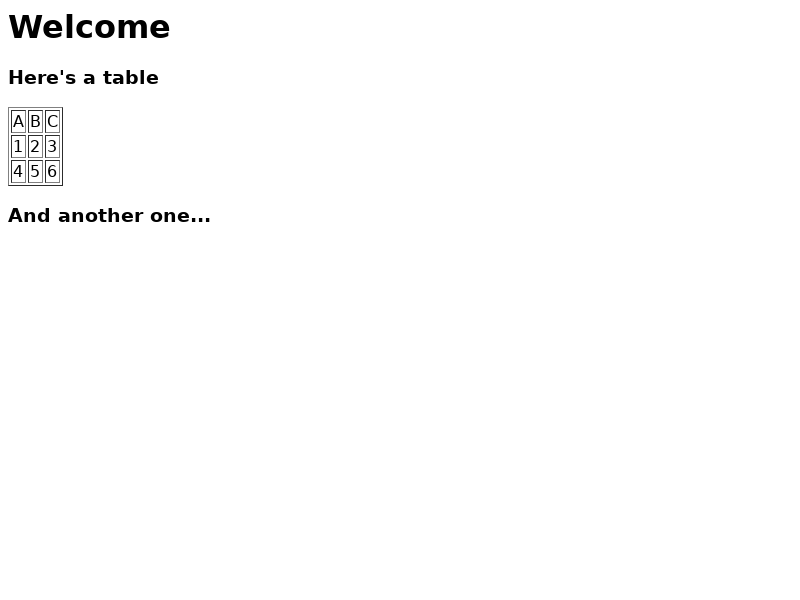

In [15]:
from IPython.core.display import Image
Image("shot1.png")

Looks like that second table wasn't loaded yet.  But if we wait a few seconds, it will be.

In [16]:
import time
time.sleep(3) # in seconds

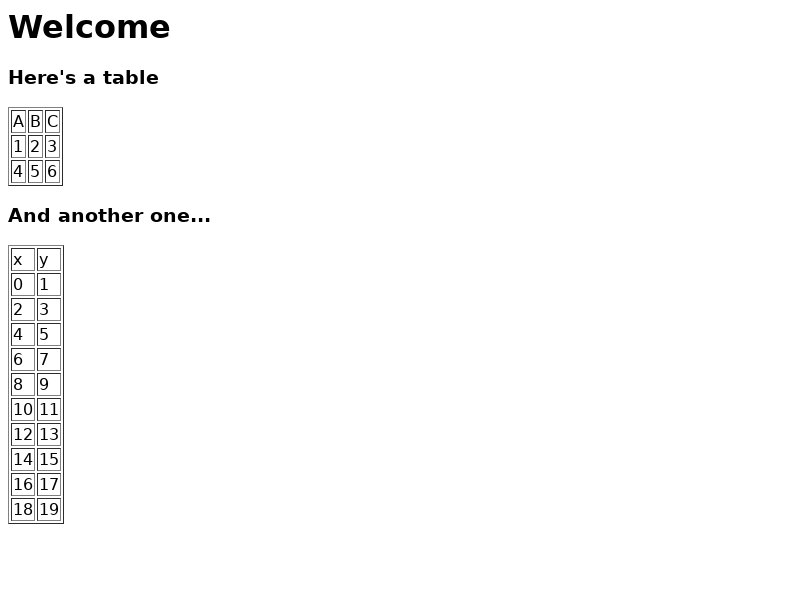

In [17]:
b.save_screenshot("shot2.png")
Image("shot2.png")

Here's what happened in the browser:
1. Chrome converted HTML tags to elements in the DOM (Document Object Model)
2. JavaScript added some elements to the DOM (for the second table)
3. the new version with both tables got shown

Selenium's `.page_source` element lets us convert the new version back to HTML (notice there are two `<table>`'s instead of the original one -- `requests` could only see the first one, but Selenium also sees the one generated by the JavaScript code).

In [18]:
print(b.page_source)

<html><head>
    <script src="https://code.jquery.com/jquery-3.4.1.js"></script>
    <script>
      function addTable() {
        var html = "<table border=1 id='coords'>\n";
        html += "<tr><td>x</td><td>y</td></tr>\n";
        for (i = 0; i < 10; i++) {
          html += "<tr><td>" + (i*2) + "</td><td>" + (i*2+1) + "</td></tr>\n";
        }
        html += "</table>";

        var t = document.createElement("div");
        t.innerHTML = html;
        document.body.appendChild(t);
      }
      
      function main() {
        setTimeout(addTable, 1000)
      }
      </script>
  </head>
  <body onload="main()">
    <h1>Welcome</h1>
    <h3>Here's a table</h3>
    <table border="1" id="alpha">
      <tbody><tr><td>A</td><td>B</td><td>C</td></tr>
      <tr><td>1</td><td>2</td><td>3</td></tr>
      <tr><td>4</td><td>5</td><td>6</td></tr>
    </tbody></table>

    <h3>And another one...</h3>
  

<div><table border="1" id="coords">
<tbody><tr><td>x</td><td>y</td></tr>
<tr><td>0</td><t

One option would be to used this updated HTML string with BeautifulSoup to search for tables and data:

In [19]:
doc = BeautifulSoup(b.page_source)
tables = doc.findAll("table")
print(f"There are {len(tables)} table(s)")

There are 2 table(s)


Alternatively, Selenium has a (somewhat clunkier) interface for directly searching for elements:

In [20]:
tables = b.find_elements_by_tag_name("table")
print(f"There are {len(tables)} table(s)")

There are 2 table(s)


Instead of BeautifulSoup `Tag` objects, we get Selenium `WebElement` objects.  Fortunately, both have a `.text` attribute to see the raw data (without surrounding HTML tags):

In [21]:
type(tables[0])

selenium.webdriver.remote.webelement.WebElement

In [22]:
print(tables[0].text)

A B C
1 2 3
4 5 6


## Conclusion

A web browser like Chrome understands both HTML and JavaScript (and is able to run JavaScript that may update the elements corresponding to HTML tags).  For simple pages, the `requests` module is great way to fetch HTML and other resources, without any JavaScript engine.  `requests` does not parse HTML, so it is often used in conjunction with BeautifulSoup (which can parse an HTML document to a searchable tree structure).

Selenium is much slower than `requests`, but it is able to control a real web browser (capable of executing JavaScript), so it allows data scientists to scrape many pages that would not be scrapable otherwise.  Selenium also provides a searchable tree of elements, like BeautifulSoup, but the methods tend to be less convenient, so one may choose to still use BeautifulSoup with Selenium (though it's less necessary than when working with `requests`).